# Generating FGSM Attacks on a Deepfake Detector Model

In [1]:
%pip freeze

/bin/bash: /opt/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
absl-py==2.1.0
accelerate==0.30.1
aiohttp==3.9.5
aiosignal==1.3.1
anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
Automat==20.2.0
Babel==2.15.0
bcrypt==3.2.0
beautifulsoup4==4.10.0
bleach==6.1.0
blinker==1.4
cachetools==5.3.3
certifi==2020.6.20
cffi==1.15.0
chardet==4.0.0
charset-normalizer==3.3.2
# Editable install with no version control (cleverhans==4.0.0)
-e /mnt/nfs/home/aaraborar/.local/lib/python3.10/site-packages
click==8.0.3
cloud-init==24.1.3
cloudpickle==3.0.0
colorama==0.4.4
comm==0.2.2
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.2.1
cryptography==3.4.8
cycler==0.12.1
datasets==2.19.2
dblatex==0.3.12
dbus-python==1.2.18
debugpy==1.8.1
decorator==4.4.2
defusedxml==0.7.1
devscripts===2.22.1ubuntu1
dill==0.3.8
distro==1.7.0
distro-info=

In [ ]:
%pip install cleverhans

## Prepare data

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

import gc
from datasets import Image, ClassLabel, Dataset as HuggingFaceDataset
from torch.utils.data import Dataset as TorchDataset

import torch

In [4]:
dataset_path = sorted(Path('/home/hssalazar/Dataset').glob('*/*/*.*'))

df = pd.DataFrame.from_dict(
    {'image': [str(file) for file in dataset_path],
     'label': [file.parts[-2] for file in dataset_path],
     'identifier': ['/'.join(file.parts[4::]) for file in dataset_path]
    }
)
print(df.shape)

df.head()

(190335, 3)


,image,label,identifier
0,/home/hssalazar/Dataset/Test/Fake/fake_0.jpg,Fake,Test/Fake/fake_0.jpg
1,/home/hssalazar/Dataset/Test/Fake/fake_1.jpg,Fake,Test/Fake/fake_1.jpg
2,/home/hssalazar/Dataset/Test/Fake/fake_10.jpg,Fake,Test/Fake/fake_10.jpg
3,/home/hssalazar/Dataset/Test/Fake/fake_100.jpg,Fake,Test/Fake/fake_100.jpg
4,/home/hssalazar/Dataset/Test/Fake/fake_1000.jpg,Fake,Test/Fake/fake_1000.jpg


In [5]:
# Create an image, label dataset from a Pandas DataFrame.
ClassLabels = ClassLabel(num_classes=2, names=['Real', 'Fake'])
# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = (
    HuggingFaceDataset.from_pandas(df)
    .cast_column('image', Image())
    .map(map_label2id, batched=True)
    .cast_column('label', ClassLabels)
)

Map:   0%|          | 0/190335 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190335 [00:00<?, ? examples/s]

In [6]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': 1,
 'identifier': 'Test/Fake/fake_0.jpg'}

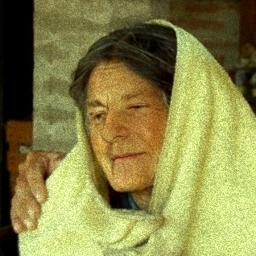

In [7]:
dataset[0]['image']

## Prepare model

In [ ]:
from transformers import ViTImageProcessor, AutoModelForImageClassification

# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection" # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)
model = AutoModelForImageClassification.from_pretrained(model_str).to('cuda')

In [9]:
# Get the size (height) of the ViT model's input images
size = processor.size["height"]

# Define a set of transformations for validation data
from torchvision.transforms import (  # Import image transformation functions
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    Resize,  # Resize images
    ToTensor,
)

convert_to_valid_tensor = Compose([
    Resize((size, size)),             # Resize images to the ViT model's input size
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std),
])

## Evaluate model

In [10]:
from transformers import pipeline
pipe = pipeline('image-classification', model_str, device='cuda')

In [11]:
from csv import DictWriter
from operator import itemgetter
from torch.utils.data import DataLoader

## Generating adversarial examples

In [13]:
class deepfake_and_real(TorchDataset):
    def __getitem__(self, idx: int):
        tensor = convert_to_valid_tensor(dataset[idx]['image'].convert("RGB")).cuda()
        identifier = dataset[idx]['identifier']
        return tensor, identifier

    def __len__(self):
        return len(dataset)

In [14]:
# Turn images into tensors
tensor_data = deepfake_and_real()
data_loader = DataLoader(tensor_data, batch_size=3, shuffle=False)

### FGM

In [15]:
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, wait
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from tqdm import tqdm

In [16]:
img_save_path = '/home/aaraborar/cs199/huggingfacevit/adversarial/fgsm_l2/'
# this directory must follow the ff structure
# fgsm_l2/
# ├─ Test/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Train/
# │  ├─ Fake/
# │  ├─ Real/
# ├─ Validation/
# │  ├─ Fake/
# │  ├─ Real/


In [17]:
def generate_fgsm_examples(model_fn, data_loader, epsilon):
    for tensor_batch, identifier_batch in tqdm(data_loader):
        adv_images = fast_gradient_method(model_fn, tensor_batch, epsilon, norm=2)
        del tensor_batch
        torch.cuda.empty_cache()
        yield adv_images, model(adv_images), identifier_batch

In [18]:
def save_cuda_tensor(image: torch.cuda.FloatTensor, identifier: str):
    perturbed_img = to_pil_image(image.to('cpu'))
    save_location = f'{img_save_path}{identifier}'
    perturbed_img.save(save_location, 'JPEG')
    torch.cuda.empty_cache()

In [ ]:
# WITH THREADING
# ONLY RUN ONCE to generate .csv of results
pending_jobs = []

with open(f'/home/aaraborar/cs199/huggingfacevit/fgsm_l2.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    softmax = torch.nn.Softmax()

    with ThreadPoolExecutor(max_workers=16) as ex:
        for images, outputs, identifiers in generate_fgsm_examples(lambda image: model(image).logits, data_loader, 0.05):
            for img, identifier in zip(images, identifiers):
                pending_jobs.append(ex.submit(save_cuda_tensor, img, identifier))
            probabilities = softmax(outputs.logits)
            winners = torch.argmax(probabilities, dim=1)
            writer.writerows({ 'label': 'Fake' if winner == 1 else 'Real', 'score': probs[winner].item(), 'identifier': identifier } for probs, winner, identifier in zip(probabilities, winners, identifiers))
            torch.cuda.empty_cache()
wait(pending_jobs)